In [1]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [14]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults
from typing import Annotated, TypedDict
import operator
from langgraph.graph import StateGraph, START, END

In [15]:
# Initialize model
llm = ChatOpenAI(model="gpt-4o", temperature=0)


# Define the graph state
class State(TypedDict):
    company: str
    summary: str
    context: Annotated[list, operator.add]

In [16]:
# Node 1: Search for recent news
def search_news(state):
    """Retrieve recent tech news about the company."""
    company = state["company"]
    tavily = TavilySearchResults(max_results=3)
    search_docs = tavily.invoke(f"Recent news about {company}")

    formatted_docs = "\n\n---\n\n".join(
        [f"<News href='{doc['url']}'>\n{doc['content']}\n</News>" for doc in search_docs]
    )
    return {"context": [formatted_docs]}

# Node 2: Get Wikipedia background
def search_background(state):
    """Retrieve company background from Wikipedia."""
    company = state["company"]
    search_docs = WikipediaLoader(query=company, load_max_docs=1).load()

    formatted_docs = "\n\n---\n\n".join(
        [f"<Wikipedia source='{doc.metadata['source']}'>\n{doc.page_content}\n</Wikipedia>" for doc in search_docs]
    )
    return {"context": [formatted_docs]}

# Node 3: Generate Investor Brief
def summarize_news(state):
    """Generate a concise investor-focused brief from retrieved context."""
    company = state["company"]
    context = "\n\n".join(state["context"])

    prompt = f"""
    You are a financial analyst. Using the information below, create an **Investor Brief**
    about **{company}**.

    Information:
    {context}

    Your brief must include:

    **1. Recent Highlights**
    - Key events, announcements, product launches, or leadership updates.

    **2. Market & Financial Implications**
    - Expected impact on business performance, stock movement, or market positioning.

    **3. Strategic Outlook**
    - Short-term outlook (next 3–6 months)
    - Risks and opportunities

    Ensure the tone is:
    - Neutral and analytical (not promotional)
    - Clear, concise, and suitable for business decision making
    """

    response = llm.invoke(prompt)
    return {"summary": response.content}


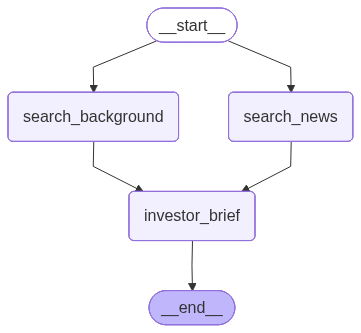

In [17]:
builder = StateGraph(State)

# Nodes
builder.add_node("search_news", search_news)
builder.add_node("search_background", search_background)
builder.add_node("investor_brief", summarize_news)  # renamed for clarity

# Parallel + merge (fan-out → fan-in)
builder.add_edge(START, "search_news")
builder.add_edge(START, "search_background")
builder.add_edge("search_news", "investor_brief")
builder.add_edge("search_background", "investor_brief")
builder.add_edge("investor_brief", END)

# Compile graph
graph = builder.compile()

# Visualize
from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
result = graph.invoke({"company": "google", "context": []})
print(result["summary"])

/var/folders/7p/7t5ggdvs7cd4c2nqjhs3hz6h0000gn/T/ipykernel_25744/805650888.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(max_results=3)


**Investor Brief: Google LLC**

---

**1. Recent Highlights**

- **AI Advancements**: In September 2025, Google announced significant upgrades to its AI capabilities across core services such as Chrome and Search. The introduction of Gemini as an AI browsing assistant in Chrome and the enhanced AI Mode in Search for visual inspiration are notable developments. Google DeepMind also introduced new robotics models, and NotebookLM gained new learning features, enhancing its utility as an AI research partner.

- **Capital Expenditure Increase**: Google has raised its capital expenditure estimates for 2025 to $91-93 billion, as revealed during the company's Q3 earnings call. This increase is attributed to a significant rise in data center spending anticipated for 2026.

- **Product Updates**: Google released a late-October 2025 update for Pixel devices, addressing a major security issue. This update precedes the expected November Android Feature Drop, which will introduce new features such a

In [19]:
result = graph.invoke({"company": "microsoft", "context": []})
print(result["summary"])

**Investor Brief: Microsoft Corporation**

---

**1. Recent Highlights**

- **AI Investments**: Microsoft has reported higher-than-expected capital expenditures of $34.9 billion in its latest quarter, primarily driven by investments in artificial intelligence (AI). This move aligns with the broader industry trend where tech giants are heavily investing in AI technologies.

- **Gaming Strategy**: In a strategic shift, Microsoft is expanding its gaming portfolio by bringing its flagship sci-fi franchise, Halo, to Sony’s PlayStation. This marks a departure from its previous exclusivity strategy, potentially broadening its gaming audience.

- **Product Developments**: Microsoft continues to enhance its productivity offerings with the introduction of Microsoft 365 Copilot, which now enables users to build apps and workflows. This is part of a broader push to integrate AI into its software suite, aiming to improve IT efficiency and user experience.

- **Leadership and Vision**: Under CEO Sat